In [10]:
# for colab
!pip install mixturelib
!sudo apt-get install language-pack-id
!sudo apt-get install language-pack-de-base

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
language-pack-id is already the newest version (1:18.04+20180712).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
language-pack-de-base is already the newest version (1:18.04+20180712).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [11]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm.notebook import tqdm

import json

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

import pickle

from sklearn.model_selection import ParameterGrid

In [12]:
from mixturelib.mixture import MixtureEM
from mixturelib.local_models import EachModelLinear, EachModel
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet

from mixturelib.regularizers import RegularizeModel

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [14]:
import locale

locale.setlocale(locale.LC_ALL, 'de_DE.utf8')

plt.rcParams["font.family"] = 'Djvu Serif'

plt.rcParams['axes.formatter.use_locale'] = True

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
def extract_picture(model):
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

    CIRCLE = np.zeros_like(TEMP)

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r
        
    idx = np.argmax(model.predict(X_tr)[1], axis = 1)
    
    return CIRCLE, idx

In [17]:
def get_data(beta=0.0, uniform_points = 0):
    np.random.seed(0)
    N = 100
    n = 3
    r1 = np.sqrt(0.5)
    r2 = np.sqrt(0.7)
    r3 = np.sqrt(1.1)
    phi = np.linspace(0, 2*np.pi, N)


    x1_0 = 0
    y1_0 = 0

    x2_0 = 2.5
    y2_0 = 4

    x3_0 = 0
    y3_0 = 5

    x = np.hstack([r1*np.sin(phi) + x1_0, r2*np.sin(phi) + x2_0, r3*np.sin(phi) + x3_0, np.random.randn(uniform_points)*1+1])
    y = np.hstack([r1*np.cos(phi) + y1_0, r2*np.cos(phi) + y2_0, r3*np.cos(phi) + y3_0, np.random.randn(uniform_points)*2+3])

    x += beta*np.random.randn(len(x))
    y += beta*np.random.randn(len(y))

    return x, y

In [18]:
beta = 0.01
uniform_points = 0

items = [{'beta': 0.0, 'uniform_points': 0}, 
         {'beta': 0.25, 'uniform_points': 0}, 
         {'beta': 0.25, 'uniform_points': 25}]

answers = dict()

for item in tqdm(items):
    beta = item['beta']
    uniform_points = item['uniform_points']

    x, y = get_data(beta, uniform_points)

    X = np.vstack([x, y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X).to(device)
    Y_tr = torch.FloatTensor(Y).view([-1,1]).to(device)

    n = len(X[0])
    K = 3
    w1 = [0, 0, 1]
    w2 = [5, 8, -20]
    w3 = [0, 10, -20]
    torch.manual_seed(0)
    LIST_w = [torch.FloatTensor(w1).view(-1,1).to(device),  
              torch.FloatTensor(w2).view(-1,1).to(device),
              torch.FloatTensor(w3).view(-1,1).to(device)]


    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device))
        
        LoM[-1].W = LIST_w[k] + 2.0 * torch.randn_like(LIST_w[k])

    HypPar = {'beta': beta}

    HpMd = HyperExpertNN(input_dim=n, output_dim = K, device = device)

    model = MixtureEM(HyperParameters = HypPar,
                      HyperModel = HpMd, 
                      ListOfModels = LoM,
                      device = device,
                      model_type='sample')

    list_of_circles = []
    for i in tqdm(range(100), leave=False):
        model.fit(X_tr, Y_tr, 1)
        list_of_circles.append(extract_picture(model))

    CIRCLE, idx = extract_picture(model)


    answers[str(item)] = x, y, list_of_circles

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

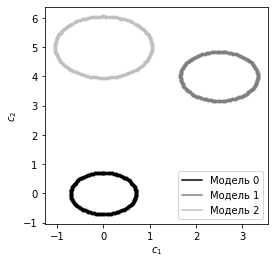

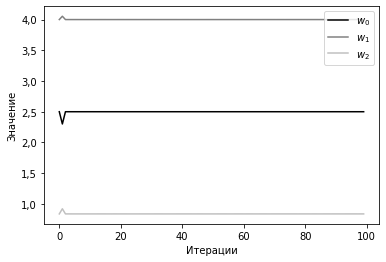

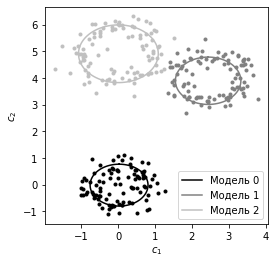

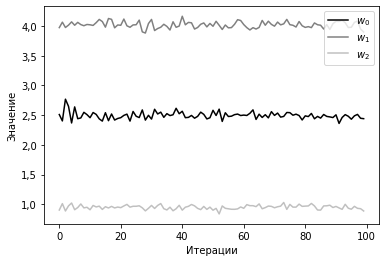

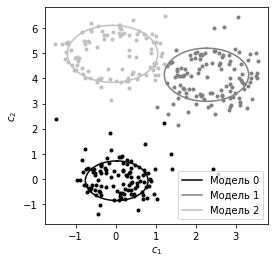

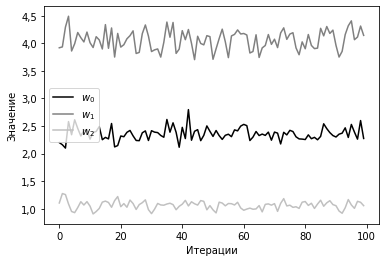

In [19]:
phi = np.linspace(0, 2*np.pi, 100)
for item in answers:
    x, y, list_of_circles = answers[item]

    CIRCLE, idx = list_of_circles[-1]

    colors = ['black', 'grey', 'silver']

    fig = plt.figure(figsize=(4, 4))
    for i in range(len(CIRCLE)):
        _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
        
        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(phi)
        y_plot = y0 + r*np.cos(phi)

        _ = plt.plot(x_plot, y_plot, '-', color = colors[i], label = 'Модель {}'.format(i))

    plt.legend(loc='best')
    plt.xlabel('$c_1$')
    plt.ylabel('$c_2$')
    plt.savefig(item+'_circles.eps', bbox_inches='tight')
    plt.show()

    for i in range(3):
        plt.plot(np.array([x[0][1][i] for x in list_of_circles]), color = colors[i], label='$w_{}$'.format(i))
        
    plt.legend(loc='best')
    plt.xlabel('Итерации')
    plt.ylabel('Значение')
    plt.savefig(item+'_circles_noise.eps', bbox_inches='tight')
    plt.show()